# Multiclass Support Vector Machine Test on The Zen Performer
    
- Fully-vectorized SVM loss function implementation
- Fully-vectorized expression for analytic gradient
- Gradient anylytical check 
- Fine tuning of learning rate and regularization
- Loss function optimization
- Results visualization


In [1]:
# Setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# To make matplotlib figures appear inline 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Notebook will reload external python modules;

%load_ext autoreload
%autoreload 2

## Dataset Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times 
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


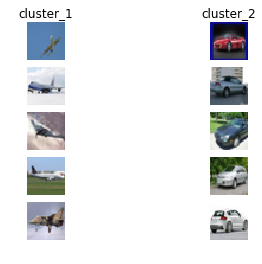

In [3]:
# Examples visualization from the dataset.

classes = ['cluster_1', 'cluster_2']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Data split into train, val, and test sets. with a subset of the training data for small developments.

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Validation set formula
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set formula
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Data Preprocessing
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Sanity check
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [6]:
# Data Preprocessing in several steps: 
# 1- Mean image computation
mean_image = np.mean(X_train, axis=0)

# 2- Mean image substraction from data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 3- Bias dimension included
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])


## SVM Classifier

In [7]:
# Naive implementation evaluation
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# Random SVM generation
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.145787


In [8]:
# Gradient check recomputation

# Loss and its gradient computations
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Gradient computation with random dimensions, and Analysis
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Gradient check once again with regularization 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -10.546257 analytic: -0.000569, relative error: 9.998920e-01
numerical: -10.712715 analytic: -0.000569, relative error: 9.998937e-01
numerical: 10.746982 analytic: -0.000569, relative error: 1.000000e+00
numerical: 5.038215 analytic: -0.000569, relative error: 1.000000e+00
numerical: -35.437550 analytic: -0.000569, relative error: 9.999679e-01
numerical: -7.557760 analytic: -0.000569, relative error: 9.998493e-01
numerical: 9.389285 analytic: -0.000569, relative error: 1.000000e+00
numerical: -3.052152 analytic: -0.000569, relative error: 9.996270e-01
numerical: -51.789160 analytic: -0.000569, relative error: 9.999780e-01
numerical: -0.145063 analytic: -0.000569, relative error: 9.921808e-01
numerical: -5.413102 analytic: 0.002243, relative error: 1.000000e+00
numerical: -4.259826 analytic: 0.005469, relative error: 1.000000e+00
numerical: -5.235794 analytic: 0.008936, relative error: 1.000000e+00
numerical: -28.437821 analytic: 0.008435, relative error: 1.000000e+00
numeric

In [9]:
# Vectorized SVM Loss Function 
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

Vectorized loss: 1.829157e-02 computed in 0.013934s


In [10]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 763.329194
iteration 100 / 1500: loss 278.262274
iteration 200 / 1500: loss 101.601955
iteration 300 / 1500: loss 37.263020
iteration 400 / 1500: loss 13.859631
iteration 500 / 1500: loss 5.349392
iteration 600 / 1500: loss 2.256011
iteration 700 / 1500: loss 1.134549
iteration 800 / 1500: loss 0.721159
iteration 900 / 1500: loss 0.572381
iteration 1000 / 1500: loss 0.509506
iteration 1100 / 1500: loss 0.491739
iteration 1200 / 1500: loss 0.482702
iteration 1300 / 1500: loss 0.480952
iteration 1400 / 1500: loss 0.482937
That took 5.118858s


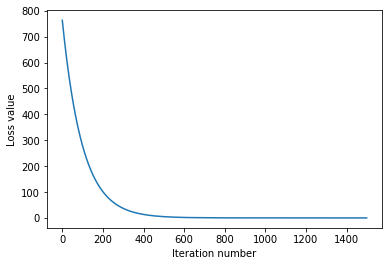

In [11]:
# Loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# Linear SVM function and evaluate the performance analysis
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365163
validation accuracy: 0.366000


In [13]:
# Hyperparameters fine tuning 

l_rates = [1e-9, 1e-7]
regularization_strengths = [2.3e4, 5.1e4]

# Dictionary results (l_rate, regularization_strength)
results = {}
best_val = -1   
best_svm = None 

for lr in l_rates:
    for reg in regularization_strengths:        
        SVM = LinearSVM()        
        _ = SVM.train(X_train, y_train, lr, reg, num_iters=2500, verbose=False)   
        
        training_pred = SVM.predict(X_train)
        training_accuracy = np.mean(y_train == training_pred)
        validation_pred = SVM.predict(X_val)
        validation_accuracy = np.mean(y_val == validation_pred)
        
        if validation_accuracy>best_val:
            best_val = validation_accuracy
            best_svm = SVM
        
        results[(lr,reg)] = (training_accuracy, validation_accuracy)

    
# Results 
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 2.300000e+04 train accuracy: 0.169837 val accuracy: 0.157000
lr 1.000000e-09 reg 5.100000e+04 train accuracy: 0.161286 val accuracy: 0.166000
lr 1.000000e-07 reg 2.300000e+04 train accuracy: 0.372224 val accuracy: 0.374000
lr 1.000000e-07 reg 5.100000e+04 train accuracy: 0.355510 val accuracy: 0.357000
best validation accuracy achieved during cross-validation: 0.374000


In [14]:
# Best SVM evaluation on Test Set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


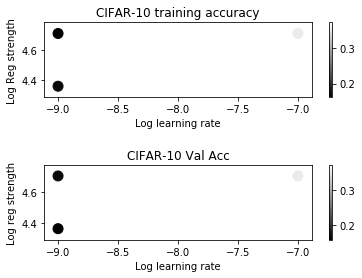

In [15]:
# Cross Validation Results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('Log learning rate')
plt.ylabel('Log Reg strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('Log learning rate')
plt.ylabel('Log reg strength')
plt.subplots_adjust(hspace=0.9)
plt.title('CIFAR-10 Val Acc')
plt.show()

In [16]:
# SVM Test Set Valuation
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


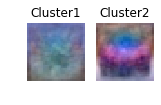

In [17]:
# Learned weights Vizualization

w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['Cluster1', 'Cluster2']
for i in range(2):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])